In [80]:
import seaborn as sns
import itertools
from scipy import stats
import tensorflow as tf
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import cPickle as pickle
import os
import seaborn as sns
from IPython.display import Image, display
from sklearn import metrics


sns.set_style("white")
sns.set_palette("husl")

class Config:
    #MATCHER = ("^(.*)_(.*)_(.*)_(.*)_(\d+)_(\d*\.?\d*)_(\d*\.?\d*)(_trial\d+)?(_epoch\d+)?")
    MATCHER = ("^(.*)_(.*)_(.*)_(.*)_(\d+)_(\d*\.?\d*)_(\d*\.?\d*)(_trial\d+)(_seed\d+)(_losses.)?(epoch_\d+)?")


    def __init__(self, filename):
        groups = self.matches(filename)
        self.strategy = groups[0]
        self.dataset = groups[1]
        self.network = groups[2]
        self.top_k = float(groups[3])
        self.pool_size = int(groups[4])
        self.lr = float(groups[5])
        self.decay = float(groups[6])
        self.trial = None
        self.epoch = None
        if groups[7]:
            unparsed_trial = groups[7]
            self.trial = int(unparsed_trial.strip("_trial"))
        if groups[10]:
            unparsed_epoch = groups[10]
            self.epoch = int(unparsed_epoch.strip("_epoch"))


    def matches(self, filename):
        import re
        return (re.match(Config.MATCHER, filename)).groups()
    
    @property
    def filename(self):
        sanitized_label = self.label.replace(" ", "").replace(":", "").split(",")
        return '-'.join([str(token) for token in sanitized_label])

        
    @property
    def label(self):
        print(self.strategy)
        if self.strategy == "topk":
            label = "{}, {}, top_{}/{}".format(self.strategy,
                                                      self.network,
                                                      self.top_k,
                                                      self.pool_size)
        elif self.strategy == "lowk":
            label = "{}, {}, lowest_{}/{}".format(self.strategy,
                                                      self.network,
                                                      self.top_k,
                                                      self.pool_size)
        elif self.strategy == "randomk":
            label = "{}, {}, random_{}/{}".format(self.strategy,
                                                      self.network,
                                                      self.top_k,
                                                      self.pool_size)
        elif self.strategy == "kath":
            label = "{}, {}, {}/{}".format(self.strategy,
                                                      self.network,
                                                      self.top_k,
                                                      self.pool_size)
        elif self.strategy == "sampling" or self.strategy == "deterministic":
            label = "{}, {}, Min: {}".format(self.strategy,
                                                   self.network,
                                                   self.top_k) 
        elif self.strategy == "baseline":
            label = "{}, {}".format(self.strategy, self.network)    
        else:
            label = ""
        #if self.trial:
        #    label += ", trial-{}".format(self.trial)
        if self.epoch:
            label += ", epoch-{}".format(self.epoch)
        return label

def write_file(plot_file_prefix):
    plot_file = "{}.pdf".format(plot_file_prefix)
    plt.savefig(plot_file)
    
    plot_file = "{}.png".format(plot_file_prefix)
    plt.savefig(plot_file, format="png", dpi=1000)
    plt.clf()

def get_percentiles(d, num_percentiles):
    xs = np.arange(0, 100, 100./num_percentiles)
    ys = [np.percentile(d, x) for x in xs]
    return xs, ys
            
def format_plot(xlabel, ylabel, label_size=10, grid=False):
    plt.tick_params(axis='y', which='major', labelsize=label_size * 1.4)
    plt.tick_params(axis='y', which='minor', labelsize=label_size * 1.2)
    plt.tick_params(axis='x', which='major', labelsize=label_size * 1.4)
    plt.tick_params(axis='x', which='minor', labelsize=label_size * 1.2)

    plt.xlabel(xlabel, fontsize=label_size * 1.6)
    plt.ylabel(ylabel, fontsize=label_size * 1.6)
    plt.tight_layout()
    plt.gca().xaxis.grid(grid)
    plt.gca().yaxis.grid(grid)
    
    leg = plt.legend(loc=0, prop={'size': label_size * .6})
    for legobj in leg.legendHandles:
        legobj.set_linewidth(2.0)


In [2]:
def plot_image_distributions(pickles_dir, plot_dir, trials=None, num_percentiles=100):
    print("In plot_image_distributions for {}".format(plot_dir))
    for filename in os.listdir(pickles_dir):
        config = Config(filename)

        if trials:
            if config.trial not in trials:
                continue
        pickles_file = os.path.join(pickles_dir, filename)
        binwidth=1
        with open(pickles_file, 'rb') as handle:
            d = pickle.load(handle)
            
            # Plot histogram
            n, bins, patches = plt.hist(d.values(),
                                        bins=range(min(d.values()), max(d.values()) + binwidth, binwidth),
                                        normed=0,
                                        facecolor='green',
                                        alpha=0.75)
            
            plt.title(config.label+" Num backprops: {}".format(sum(d.values())))
            plt.xlim(0, max(d.values()) + 1)
            plt.xlabel("Num backprops")
            plt.ylabel("Num images")
            subplot_dir = os.path.join(plot_dir, "images_dist")
            if not os.path.isdir(subplot_dir):
                os.mkdir(subplot_dir)
            plt.tight_layout()
            plot_prefix = os.path.join(subplot_dir, filename)
            write_file(plot_prefix)
            
            # Plot percentiles
            plt.clf()
            xs, ys = get_percentiles(d.values(), num_percentiles)
            plt.plot(xs, ys)
            plt.title(config.label+" Num backprops: {}".format(sum(d.values())))
            plt.xlabel("Percentile")
            plt.ylabel("Num backprops per image")
            subplot_dir = os.path.join(plot_dir, "images_percentile")
            if not os.path.isdir(subplot_dir):
                os.mkdir(subplot_dir)
            plt.tight_layout()
            plot_prefix = os.path.join(subplot_dir, filename)
            write_file(plot_prefix)

In [3]:
def plot_confidence_distributions(pickles_dir, plot_dir, max_epoch=None, trials=None, num_percentiles=100):
    print("In plot_confidence_distributions for {}".format(plot_dir))
    for filename in os.listdir(pickles_dir):
        config = Config(filename)
        if trials:
            if config.trial not in trials:
                continue
        pickles_file = os.path.join(pickles_dir, filename)
        binwidth=1
        with open(pickles_file, 'rb') as handle:
            print(pickles_file)
            d = pickle.load(handle)
            for epoch, data in d.iteritems():
                if max_epoch is not None:
                    if epoch > max_epoch:
                        break
                
                # Plot histogram
                probs = [int(c*100) for c in data["confidences"]]
                num_backpropped = data["num_backpropped"]
                n, bins, patches = plt.hist(probs,
                                            bins=range(min(probs), max(probs) + binwidth, binwidth),
                                            normed=0,
                                            facecolor='green',
                                            alpha=0.75)
                plt.title("{}, {} backpropped".format(config.label, num_backpropped))
                plt.xlabel("Probability of target")
                plt.ylabel("Frequency")
                subplot_dir = os.path.join(plot_dir, "target_confidences")
                if not os.path.isdir(subplot_dir):
                    os.mkdir(subplot_dir)
                plot_prefix = os.path.join(subplot_dir, "{}_epoch{}_{}backpropped".format(filename,
                                                                              epoch,
                                                                              num_backpropped))
                          
                plt.tight_layout()
                write_file(plot_prefix)
                          
                # Plot percentiles
                plt.clf()
                xs, ys = get_percentiles(probs, num_percentiles)
                plt.plot(xs, ys)
                auc = metrics.auc(xs, ys)
                plt.title(config.label+" AUC: {}".format(auc))
                plt.xlabel("Percentile")
                plt.ylabel("Target confidence")
                subplot_dir = os.path.join(plot_dir, "target_confidences_percentiles")
                if not os.path.isdir(subplot_dir):
                    os.mkdir(subplot_dir)
                plt.tight_layout()
                plot_prefix = os.path.join(subplot_dir, "{}_epoch{}_{}backpropped".format(filename,
                                                                                          epoch,
                                                                                          num_backpropped))
                write_file(plot_prefix)

                # Wow, hack
                random_data_dir = os.path.join(subplot_dir, "data")
                if not os.path.isdir(random_data_dir):
                    os.mkdir(random_data_dir)
                extra_filename = "{}_epoch{}_{}backpropped.txt".format(filename,
                                                                       epoch,
                                                                       num_backpropped)
                print("Extra filename: {}".format(extra_filename))
                with open(extra_filename, "w+") as f:
                    for x, y in zip(xs, ys):
                        line = "{},{}\n".format(x, y)
                        f.write(line)
                                        


In [4]:
def analyze_stdev(stdev_by_image_id, filename, src_dir="../data/images/cifar10_by_id", top_k=10):
    config = Config(filename)
    print("Analyzing stdevs for {}".format(config.label))
    stdevs = stdev_by_image_id.values()
    n, bins, patches = plt.hist(stdevs,
                                10,
                                normed=0,
                                alpha=0.8)            
    plt.title(config.label)
    plt.xlabel("Probability stdev")
    plt.ylabel("Frequency")

    subplot_dir = os.path.join(plot_dir, "probabilities_by_image")
    if not os.path.isdir(subplot_dir):
        os.mkdir(subplot_dir)
    plt.tight_layout()
    plot_prefix = os.path.join(subplot_dir, filename + "_stdev")
    write_file(plot_prefix)

    sorted_ids = sorted(stdev_by_image_id, key=lambda k: stdev_by_image_id[k])
    
    # Show image_ids with highest stdev
    print("Images from sample with highest stdev")
    for image_id in list(reversed(sorted_ids))[:top_k]:
        src_file = os.path.join(src_dir, "image-{}.png".format(image_id))
        display(Image(filename=src_file))

    # Show image_ids with lowest stdev
    print("Images from sample with lowest stdev")
    for image_id in sorted_ids[:top_k]:
        src_file = os.path.join(src_dir, "image-{}.png".format(image_id))
        display(Image(filename=src_file))
              

In [71]:
def plot_probability_timelines(pickles_dir, plot_dir, max_ids=None, trials=None):
    print("In plot_probability_timelines for {}".format(plot_dir))
    palette = itertools.cycle(sns.color_palette())

    for filename in os.listdir(pickles_dir):
        config = Config(filename)
        if trials:
            if config.trial not in trials:
                continue
        pickles_file = os.path.join(pickles_dir, filename)
        with open(pickles_file, 'rb') as handle:
            d = pickle.load(handle)
            stdev_by_image_id = {}
            for image_id, ys in d.iteritems():
                xs = range(len(ys))
                stdev_by_image_id[image_id] = np.std(ys)
                if max_ids <= image_id:
                    break
                plt.plot(xs, ys, color=next(palette))
            plt.xlabel("Epochs")
            plt.ylabel("Probability of Selection")

            subplot_dir = os.path.join(plot_dir, "probabilities_by_image")
            if not os.path.isdir(subplot_dir):
                os.mkdir(subplot_dir)
            plot_prefix = os.path.join(subplot_dir, config.filename)
            plt.tight_layout()
            plt.xlim(0, 100)
            print("Probability timeline: {}".format(plot_prefix))
            write_file(plot_prefix)
            
           # analyze_standard_deviations
            analyze_stdev(stdev_by_image_id, filename)

In [6]:
def plot_probability_distributions(pickles_dir, plot_dir, max_ids=None, trials=None):
    print("In plot_probability_timelines for {}".format(plot_dir))
    palette = itertools.cycle(sns.color_palette())

    for filename in os.listdir(pickles_dir):
        config = Config(filename)
        if trials:
            if config.trial not in trials:
                continue
        pickles_file = os.path.join(pickles_dir, filename)
        with open(pickles_file, 'rb') as handle:
            d = pickle.load(handle)
            probs = []
            for arr in d.values():
                probs.append(arr[-1])
            n, bins, patches = plt.hist(probs,
                                        50,
                                        normed=0,
                                        facecolor='green',
                                        alpha=0.75)
            
            plt.title("{}, {} epochs".format(config.label, len(probs)))
            plt.xlabel("Select Probability")
            plt.ylabel("Distribution")
            plt.show()


In [81]:

def plot_losses_cdf(pickles_dir, plot_dir, trials=None):
    losses_plot_dir = os.path.join(plot_dir, "losses")
    if not os.path.exists(losses_plot_dir):
        os.makedirs(losses_plot_dir)
    all_losses = []
    for filename in os.listdir(pickles_dir):
        config = Config(filename)
        if trials:
            if config.trial not in trials:
                continue
        n_bins = 5000
        pickles_file = os.path.join(pickles_dir, filename)
        with open(pickles_file, "rb") as handle:
            d = pickle.load(handle)
            all_losses += d
            if False:
                n, bins, patches = plt.hist(d, n_bins, normed=1, linewidth=2, histtype='step',
                                           cumulative=True, label='Epoch {}'.format(config.epoch))
                plotfile = os.path.join(losses_plot_dir, filename)
                plt.xscale('log')
                format_plot("Cross-Entropy Loss (log)", "CDF")
                write_file(plotfile)
                plt.clf()
    min_loss = min(all_losses)
    max_loss = max(all_losses)
    delta = max_loss - min_loss
    percentages = [0.01, 0.1, 0.5, 1]
    for percent in percentages:
        thresh = delta * (percent / 100.) + min_loss
        percentile = stats.percentileofscore(all_losses, thresh)
        print(percent, thresh, percentile)
    normalized_losses = [l / float(max_loss) for l in all_losses]
    if True:
        n, bins, patches = plt.hist(all_losses, n_bins, normed=1, linewidth=2, histtype='step', cumulative=True)
        plotfile = os.path.join(losses_plot_dir, "all_losses_log")
        format_plot("Cross-entropy Loss", "CDF")
        write_file(plotfile)
        plt.clf()

        n, bins, patches = plt.hist(all_losses, n_bins, normed=1, linewidth=2, histtype='step', cumulative=True)
        plotfile = os.path.join(losses_plot_dir, "all_losses_log")
        plt.xscale('log')
        format_plot("Cross-entropy Loss (log)", "CDF")
        write_file(plotfile)
        plt.clf()
    
    

In [62]:
import collections

def plot_loss_timelines(pickles_dir, plot_dir, max_ids=None, trials=None):
    print("In plot_loss_timelines for {}".format(plot_dir))
    palette = itertools.cycle(sns.color_palette())
    loss_by_image_by_epoch = {}

    for filename in os.listdir(pickles_dir):
        print("Parsing {}".format(filename))
        config = Config(filename)
        if trials:
            if config.trial not in trials:
                continue
        pickles_file = os.path.join(pickles_dir, filename)
        with open(pickles_file, 'rb') as handle:
            d = pickle.load(handle)
            for i, loss in enumerate(d):
                if max_ids <= i:
                    break
                if i not in loss_by_image_by_epoch.keys():
                    loss_by_image_by_epoch[i] = {}
                loss_by_image_by_epoch[i][config.epoch] = loss
    for image_id, loss_by_epoch in loss_by_image_by_epoch.iteritems():
        print("Plotting image_id {}".format(image_id))
        od = collections.OrderedDict(sorted(loss_by_epoch.items()))
        xs = [epoch for epoch, loss in od.iteritems()]
        ys = [loss for epoch, loss in od.iteritems()]
        plt.plot(xs, ys)
    plt.title(config.label)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plot_prefix = os.path.join(plot_dir, "losses_by_image")
    plt.tight_layout()
    print("Loss timeline: {}".format(plot_prefix))
    write_file(plot_prefix)


In [15]:
def count_flips(arr):
    prev = False
    flips = 0
    for a in arr:
        if a != prev:
            flips += 1
            prev = a
    return flips
    
def plot_selects(pickles_dir, plot_dir, trials=None):
    selects_plot_dir = os.path.join(plot_dir, "selects")
    if not os.path.exists(selects_plot_dir):
        os.makedirs(selects_plot_dir)
    for filename in os.listdir(pickles_dir):
        config = Config(filename)
        if trials:
            if config.trial not in trials:
                continue
        pickles_file = os.path.join(pickles_dir, filename)
        with open(pickles_file, "rb") as handle:
            d = pickle.load(handle)
            flips = []
            for image_id, selects in d.iteritems():
                flips.append(count_flips(selects))
            n, bins, patches = plt.hist(flips,
                                        50,
                                        normed=0,
                                        alpha=0.75)
        file_prefix = os.path.join(selects_plot_dir, filename)
        format_plot("No. of switches over training", "No. of Images")
        write_file(file_prefix)
    
            

In [28]:
def plot_experiment(experiment_dir,
                    plot_dir,
                    max_ids=0,
                    run_image_id_hist = False,
                    run_target_confidences = False,
                    run_probability_timelines = False,
                    run_probability_dist = False,
                    run_losses_analysis = False,
                    run_selects_analysis = False,
                    trials=None):
    pickles_dir = os.path.join(experiment_dir, "pickles")
    if os.path.isdir(pickles_dir):
        if run_probability_timelines:
            probabilities_dir = os.path.join(pickles_dir, "probabilities_by_image")
            if os.path.isdir(probabilities_dir):
                plot_probability_timelines(probabilities_dir,
                                           plot_dir,
                                           max_ids=max_ids,
                                           trials=trials)
        if run_target_confidences:
            target_confidences_dir = os.path.join(pickles_dir, "target_confidences")
            if os.path.isdir(target_confidences_dir):
                plot_confidence_distributions(target_confidences_dir, plot_dir, trials=trials)
        if run_image_id_hist:
            image_id_hist_dir = os.path.join(pickles_dir, "image_id_hist")
            if os.path.isdir(image_id_hist_dir):
                plot_image_distributions(image_id_hist_dir, plot_dir, trials=trials)
        if run_probability_dist:
            probability_dist_dir = os.path.join(pickles_dir, "probabilities_by_image")
            if os.path.isdir(probability_dist_dir):
                plot_probability_distributions(probability_dist_dir, plot_dir, trials=trials)
        if run_losses_analysis:
            losses_dir = os.path.join(pickles_dir, "losses")
            if os.path.isdir(losses_dir):
                plot_losses_cdf(losses_dir, plot_dir, trials=trials)
                plot_loss_timelines(losses_dir, plot_dir, trials=trials, max_ids=max_ids)
        if run_selects_analysis:
            selects_dir = os.path.join(pickles_dir, "selects_by_image")
            if os.path.isdir(selects_dir):
                plot_selects(selects_dir, plot_dir, trials=trials)
            

%matplotlib inline

In plot_probability_timelines for ../plots/batch_stats/190514_selects_2/190514_2
sampling
Probability timeline: ../plots/batch_stats/190514_selects_2/190514_2/probabilities_by_image/sampling-mobilenetv2-Min0.0
sampling
Analyzing stdevs for sampling, mobilenetv2, Min: 0.0
sampling
Images from sample with highest stdev


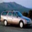

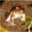

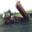

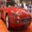

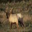

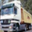

Images from sample with lowest stdev


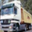

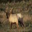

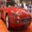

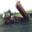

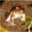

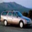

sampling
Probability timeline: ../plots/batch_stats/190514_selects_2/190514_2/probabilities_by_image/sampling-mobilenetv2-Min1.0
sampling
Analyzing stdevs for sampling, mobilenetv2, Min: 1.0
sampling
Images from sample with highest stdev


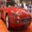

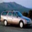

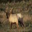

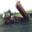

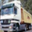

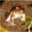

Images from sample with lowest stdev


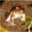

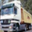

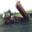

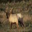

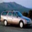

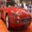

(0.01, 0.005181303405761719, 55.647582262355186)
(0.1, 0.05181303405761719, 66.35220501593024)
(0.5, 0.25906517028808596, 75.07803779754151)
(1, 0.5181303405761719, 80.24499446684528)
In plot_loss_timelines for ../plots/batch_stats/190514_selects_2/190514_2
Parsing kath-biased_cifar10_mobilenetv2_1_128_512_0.0005_trial1_seed1337_losses.epoch_0.pickle
Parsing kath-biased_cifar10_mobilenetv2_1_128_512_0.0005_trial1_seed1337_losses.epoch_10.pickle
Parsing kath-biased_cifar10_mobilenetv2_1_128_512_0.0005_trial1_seed1337_losses.epoch_100.pickle
Parsing kath-biased_cifar10_mobilenetv2_1_128_512_0.0005_trial1_seed1337_losses.epoch_110.pickle
Parsing kath-biased_cifar10_mobilenetv2_1_128_512_0.0005_trial1_seed1337_losses.epoch_120.pickle
Parsing kath-biased_cifar10_mobilenetv2_1_128_512_0.0005_trial1_seed1337_losses.epoch_130.pickle
Parsing kath-biased_cifar10_mobilenetv2_1_128_512_0.0005_trial1_seed1337_losses.epoch_140.pickle
Parsing kath-biased_cifar10_mobilenetv2_1_128_512_0.0005_trial1_se

Plotting image_id 4
sampling
Loss timeline: ../plots/batch_stats/190514_selects_2/190514_2/losses_by_image
In plot_probability_timelines for ../plots/batch_stats/190514_selects_2/190517_baseline_selectprobs
sampling
Probability timeline: ../plots/batch_stats/190514_selects_2/190517_baseline_selectprobs/probabilities_by_image/sampling-mobilenetv2-Min0.0
sampling
Analyzing stdevs for sampling, mobilenetv2, Min: 0.0
sampling
Images from sample with highest stdev


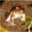

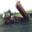

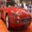

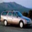

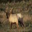

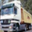

Images from sample with lowest stdev


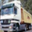

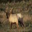

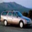

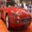

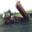

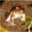

(0.01, 0.0012450904846191407, 38.217)
(0.1, 0.012450904846191407, 57.322833333333335)
(0.5, 0.06225452423095703, 68.685)
(1, 0.12450904846191406, 73.2595)
In plot_loss_timelines for ../plots/batch_stats/190514_selects_2/190517_baseline_selectprobs
Parsing sampling_cifar10_mobilenetv2_0_128_1024_0.0005_trial1_seed1337_losses.epoch_0.pickle
Parsing sampling_cifar10_mobilenetv2_0_128_1024_0.0005_trial1_seed1337_losses.epoch_10.pickle
Parsing sampling_cifar10_mobilenetv2_0_128_1024_0.0005_trial1_seed1337_losses.epoch_100.pickle
Parsing sampling_cifar10_mobilenetv2_0_128_1024_0.0005_trial1_seed1337_losses.epoch_110.pickle
Parsing sampling_cifar10_mobilenetv2_0_128_1024_0.0005_trial1_seed1337_losses.epoch_20.pickle
Parsing sampling_cifar10_mobilenetv2_0_128_1024_0.0005_trial1_seed1337_losses.epoch_30.pickle
Parsing sampling_cifar10_mobilenetv2_0_128_1024_0.0005_trial1_seed1337_losses.epoch_40.pickle
Parsing sampling_cifar10_mobilenetv2_0_128_1024_0.0005_trial1_seed1337_losses.epoch_50.pickle

<Figure size 432x288 with 0 Axes>

In [82]:
plot_home_dir = "../plots/batch_stats"

experiment_batch_name = "190514_selects_2"
plot_home_dir += "/{}".format(experiment_batch_name)

experiment_names = ["190514_2", "190517_baseline_selectprobs"]
for experiment_name in experiment_names:
    experiment_dir = "../data/output/cifar10/{}".format(experiment_name)
    plot_dir = "{}/{}".format(plot_home_dir, experiment_name)
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    plot_experiment(experiment_dir,
                    plot_dir,
                    trials=[1],
                    max_ids=5,
                    run_selects_analysis=False,
                    run_probability_timelines=True,
                    run_losses_analysis=True)